In [3]:
from __future__ import print_function

import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

In [4]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

In [5]:
train_set = torchvision.datasets.CIFAR10('./datasets', train=True,
                                         download=True, transform=transform)
test_set = torchvision.datasets.CIFAR10('./datasets', train=False,
                                        download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=128,
                                           shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=100,
                                          shuffle=False, num_workers=4)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:12<00:00, 13117956.01it/s]


Extracting ./datasets/cifar-10-python.tar.gz to ./datasets
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


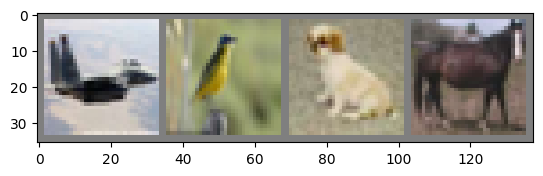

In [27]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5
    plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))
    plt.show()

image_iter = iter(train_loader)
images, _ = next(image_iter)
imshow(torchvision.utils.make_grid(images[:4]))

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = torch.device('cpu')
print(device)

cuda


### BasicBlock


In [8]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels)
        )
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != self.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * out_channels),
            )

    def forward(self, x):
        out = self.features(x)
        out += self.shortcut(x)
        out = torch.relu(out)
        return out

In [9]:
basic_block = BasicBlock(64, 128)
print(basic_block)
x = torch.randn(2, 64, 32, 32)
y = basic_block(x)
print(y.shape)

BasicBlock(
  (features): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (shortcut): Sequential(
    (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)
torch.Size([2, 128, 32, 32])


In [10]:
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_channels, zip_channels, stride=1):
        super(Bottleneck, self).__init__()
        out_channels = self.expansion * zip_channels
        self.features = nn.Sequential(
            nn.Conv2d(in_channels, zip_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(zip_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(zip_channels, zip_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(zip_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(zip_channels, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels)
        )
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.features(x)
        out += self.shortcut(x)
        out = torch.relu(out)
        return out

In [11]:
bottleneck = Bottleneck(256, 128)
print(bottleneck)
x = torch.randn(2, 256, 32, 32)
y = bottleneck(x)
print(y.shape)

Bottleneck(
  (features): Sequential(
    (0): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(128, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (7): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (shortcut): Sequential(
    (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)
torch.Size([2, 512, 32, 32])


### ResNet

In [23]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.avg_pool = nn.AvgPool2d(kernel_size=4)
        self.classifer = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.features(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.classifer(out)
        return out

In [13]:
def ResNet18():
    return ResNet(BasicBlock, [2,2,2,2])

def ResNet34():
    return ResNet(BasicBlock, [3,4,6,3])

def ResNet50():
    return ResNet(Bottleneck, [3,4,6,3])

def ResNet101():
    return ResNet(Bottleneck, [3,4,23,3])

def ResNet152():
    return ResNet(Bottleneck, [3,8,36,3])

In [14]:
net = ResNet34().to(device)
print(net)
if device == 'cuda':
    net = nn.DataParallel(net)
    torch.backends.cudnn.benchmark = True

ResNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer1): Sequential(
    (0): BasicBlock(
      (features): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (features): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    

In [15]:
x = torch.randn(2, 3, 32, 32).to(device)
y = net(x)
print(y.shape)

torch.Size([2, 10])


In [16]:
lr = 1e-1
momentum = 0.9
weight_decay = 5e-4

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, threshold=0.1, patience=3, verbose=True)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [17]:
# Training
def train(epoch):
    print('\nEpoch: %d' % (epoch))
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        if batch_idx % 100 == 99:    # print every 100 mini-batches
            print('[%d, %5d] loss: %.6f |  Acc: %.3f%% (%d/%d)' %
                  (epoch + 1, batch_idx + 1, train_loss, 100.*correct/total, correct, total))
    return train_loss

In [18]:
load_model = False
if load_model:
    checkpoint = torch.load('./checkpoint/res18.ckpt')
    net.load_state_dict(checkpoint['net'])
    start_epoch = checkpoint['epoch']
else:
    start_epoch = 0
print('start_epoch: %s' % start_epoch)

start_epoch: 0


In [22]:
for epoch in range(start_epoch, 5):
    loss = train(epoch)
    print('Total loss: %.6f' % loss)
    start_epoch = epoch
    scheduler.step(loss, epoch=epoch)


Epoch: 0
[1,   100] loss: 162.864768 |  Acc: 39.328% (5034/12800)
[1,   200] loss: 316.456962 |  Acc: 41.074% (10515/25600)
[1,   300] loss: 461.749114 |  Acc: 43.021% (16520/38400)
Total loss: 587.647433

Epoch: 1


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:1056: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


[2,   100] loss: 130.181243 |  Acc: 52.523% (6723/12800)
[2,   200] loss: 256.232784 |  Acc: 53.441% (13681/25600)
[2,   300] loss: 375.477758 |  Acc: 54.789% (21039/38400)
Total loss: 477.473282

Epoch: 2
[3,   100] loss: 103.868794 |  Acc: 63.008% (8065/12800)
[3,   200] loss: 204.190912 |  Acc: 63.582% (16277/25600)
[3,   300] loss: 298.337758 |  Acc: 64.581% (24799/38400)
Total loss: 381.658896

Epoch: 3
[4,   100] loss: 85.054049 |  Acc: 69.797% (8934/12800)
[4,   200] loss: 168.236571 |  Acc: 70.324% (18003/25600)
[4,   300] loss: 249.585029 |  Acc: 70.617% (27117/38400)
Total loss: 320.459975

Epoch: 4
[5,   100] loss: 73.632154 |  Acc: 73.641% (9426/12800)
[5,   200] loss: 146.805877 |  Acc: 74.035% (18953/25600)
[5,   300] loss: 216.526700 |  Acc: 74.464% (28594/38400)
Total loss: 279.592840


In [24]:
save_model = True
if save_model:
    state = {
        'net': net.state_dict(),
        'epoch': epoch,
    }
    os.makedirs('checkpoint', exist_ok=True)
    torch.save(state, './checkpoint/res18.ckpt')

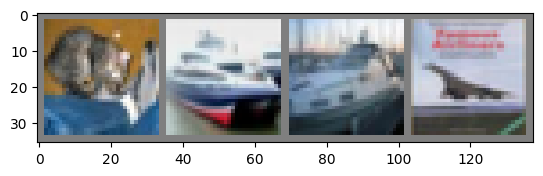

GroundTruth:    cat  ship  ship plane
Predicted:    dog plane horse  bird
Accuracy of the network on the 10000 test images: 74 %
Accuracy of plane : 84 %
Accuracy of   car : 81 %
Accuracy of  bird : 65 %
Accuracy of   cat : 60 %
Accuracy of  deer : 53 %
Accuracy of   dog : 71 %
Accuracy of  frog : 81 %
Accuracy of horse : 78 %
Accuracy of  ship : 81 %
Accuracy of truck : 86 %


In [26]:
dataiter = iter(test_loader)
images, labels = next(dataiter)
images = images[:4]
labels = labels[:4]
# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

outputs = net(images.to(device))
_, predicted = torch.max(outputs.cpu(), 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))